In [1]:
import pandas as pd
import numpy as np

import string
import matplotlib
import matplotlib.pyplot as plt

from RainySeason import *
from utils import *
from taylorDiagram import *

# some matplotlib setups
mpl_settings() 

# load data

In [2]:
### prepare data

# RS metric parameters
pS = pd.read_csv(r'./params/RSO_params_afterOptim.csv',index_col=0)
pE = pd.read_csv(r'./params/RSE_params_afterOptim.csv',index_col=0)

# target LSP data
lsp = pd.read_csv('./inputs/LSP_targets.csv',index_col=0,parse_dates=True)
SOS_w = lsp['SOS_no_lag'] - lsp['lag_WRF']
SOS_c = lsp['SOS_no_lag'] - lsp['lag_CHIRPS']
SOS_a = lsp['SOS_no_lag'] - lsp['lag_AWS']
SOS_b = lsp['SOS_no_lag'] # for bucket model only

EOS_w = lsp['EOS_no_lag'] - lsp['lag_WRF']
EOS_c = lsp['EOS_no_lag'] - lsp['lag_CHIRPS']
EOS_a = lsp['EOS_no_lag'] - lsp['lag_AWS']
EOS_b = lsp['EOS_no_lag'] # for bucket model only

# precipitation data
data = pd.read_csv('..\ALL_ts_2000_2018.csv',index_col=0,parse_dates=True)
data = data[['AWS','CHIRPS_mask','WRF_mask']]

ts_w = data['WRF_mask']
ts_c = data['CHIRPS_mask']
ts_a = data['AWS']

# Fig.02: RSO - SOS<sub>NDVI</sub>

In [3]:
### prepare RSO plot
colors = ['Grey', '#2D9B4E', '#B5A100', '#5B276D']
timeseries = [ts_w,ts_w,ts_c,ts_a]
validation = [SOS_w,SOS_w,SOS_c,SOS_a]
param_idx = ['Gu','Cl','Ga','FP','JD','Bu']
label_pos = ['top','upmid','lowmid','bottom']
models = [gurgiser_RSO,climandes_RSO,garcia_RSO,FP_RSO,JD_RSO,bucket,Liebmann,CookBuckley_2phase]
names = ['Gurgiser','Climandes','Garcia','FP','JD','Bucket','LM','CB']
markers = ['x','o','o','o']
alphas = [.5,1,1,1]
backgrounds = ['#785EF0','#FFB000','#DC267F']
alpha = int(0.1 * 255)  
alpha_hex = format(alpha, '02x')  
param_subscripts = [['p','p','d','d','d','p'],
                    ['p','p','d','d','d','p'],
                    ['p','d','d','d','p'],
                    ['p','d','p','p'],
                    ['p','d','d','p','d','d']]
col_labels = [generate_col_labels(param_subscripts[i]) for i in range(len(param_subscripts))] + [['$BWC_{in}$','$BWC_{mx}$','$BWC_{mn}$','$t_{RSO}$','$t_{RSE}$','$BD$','$ET$']]

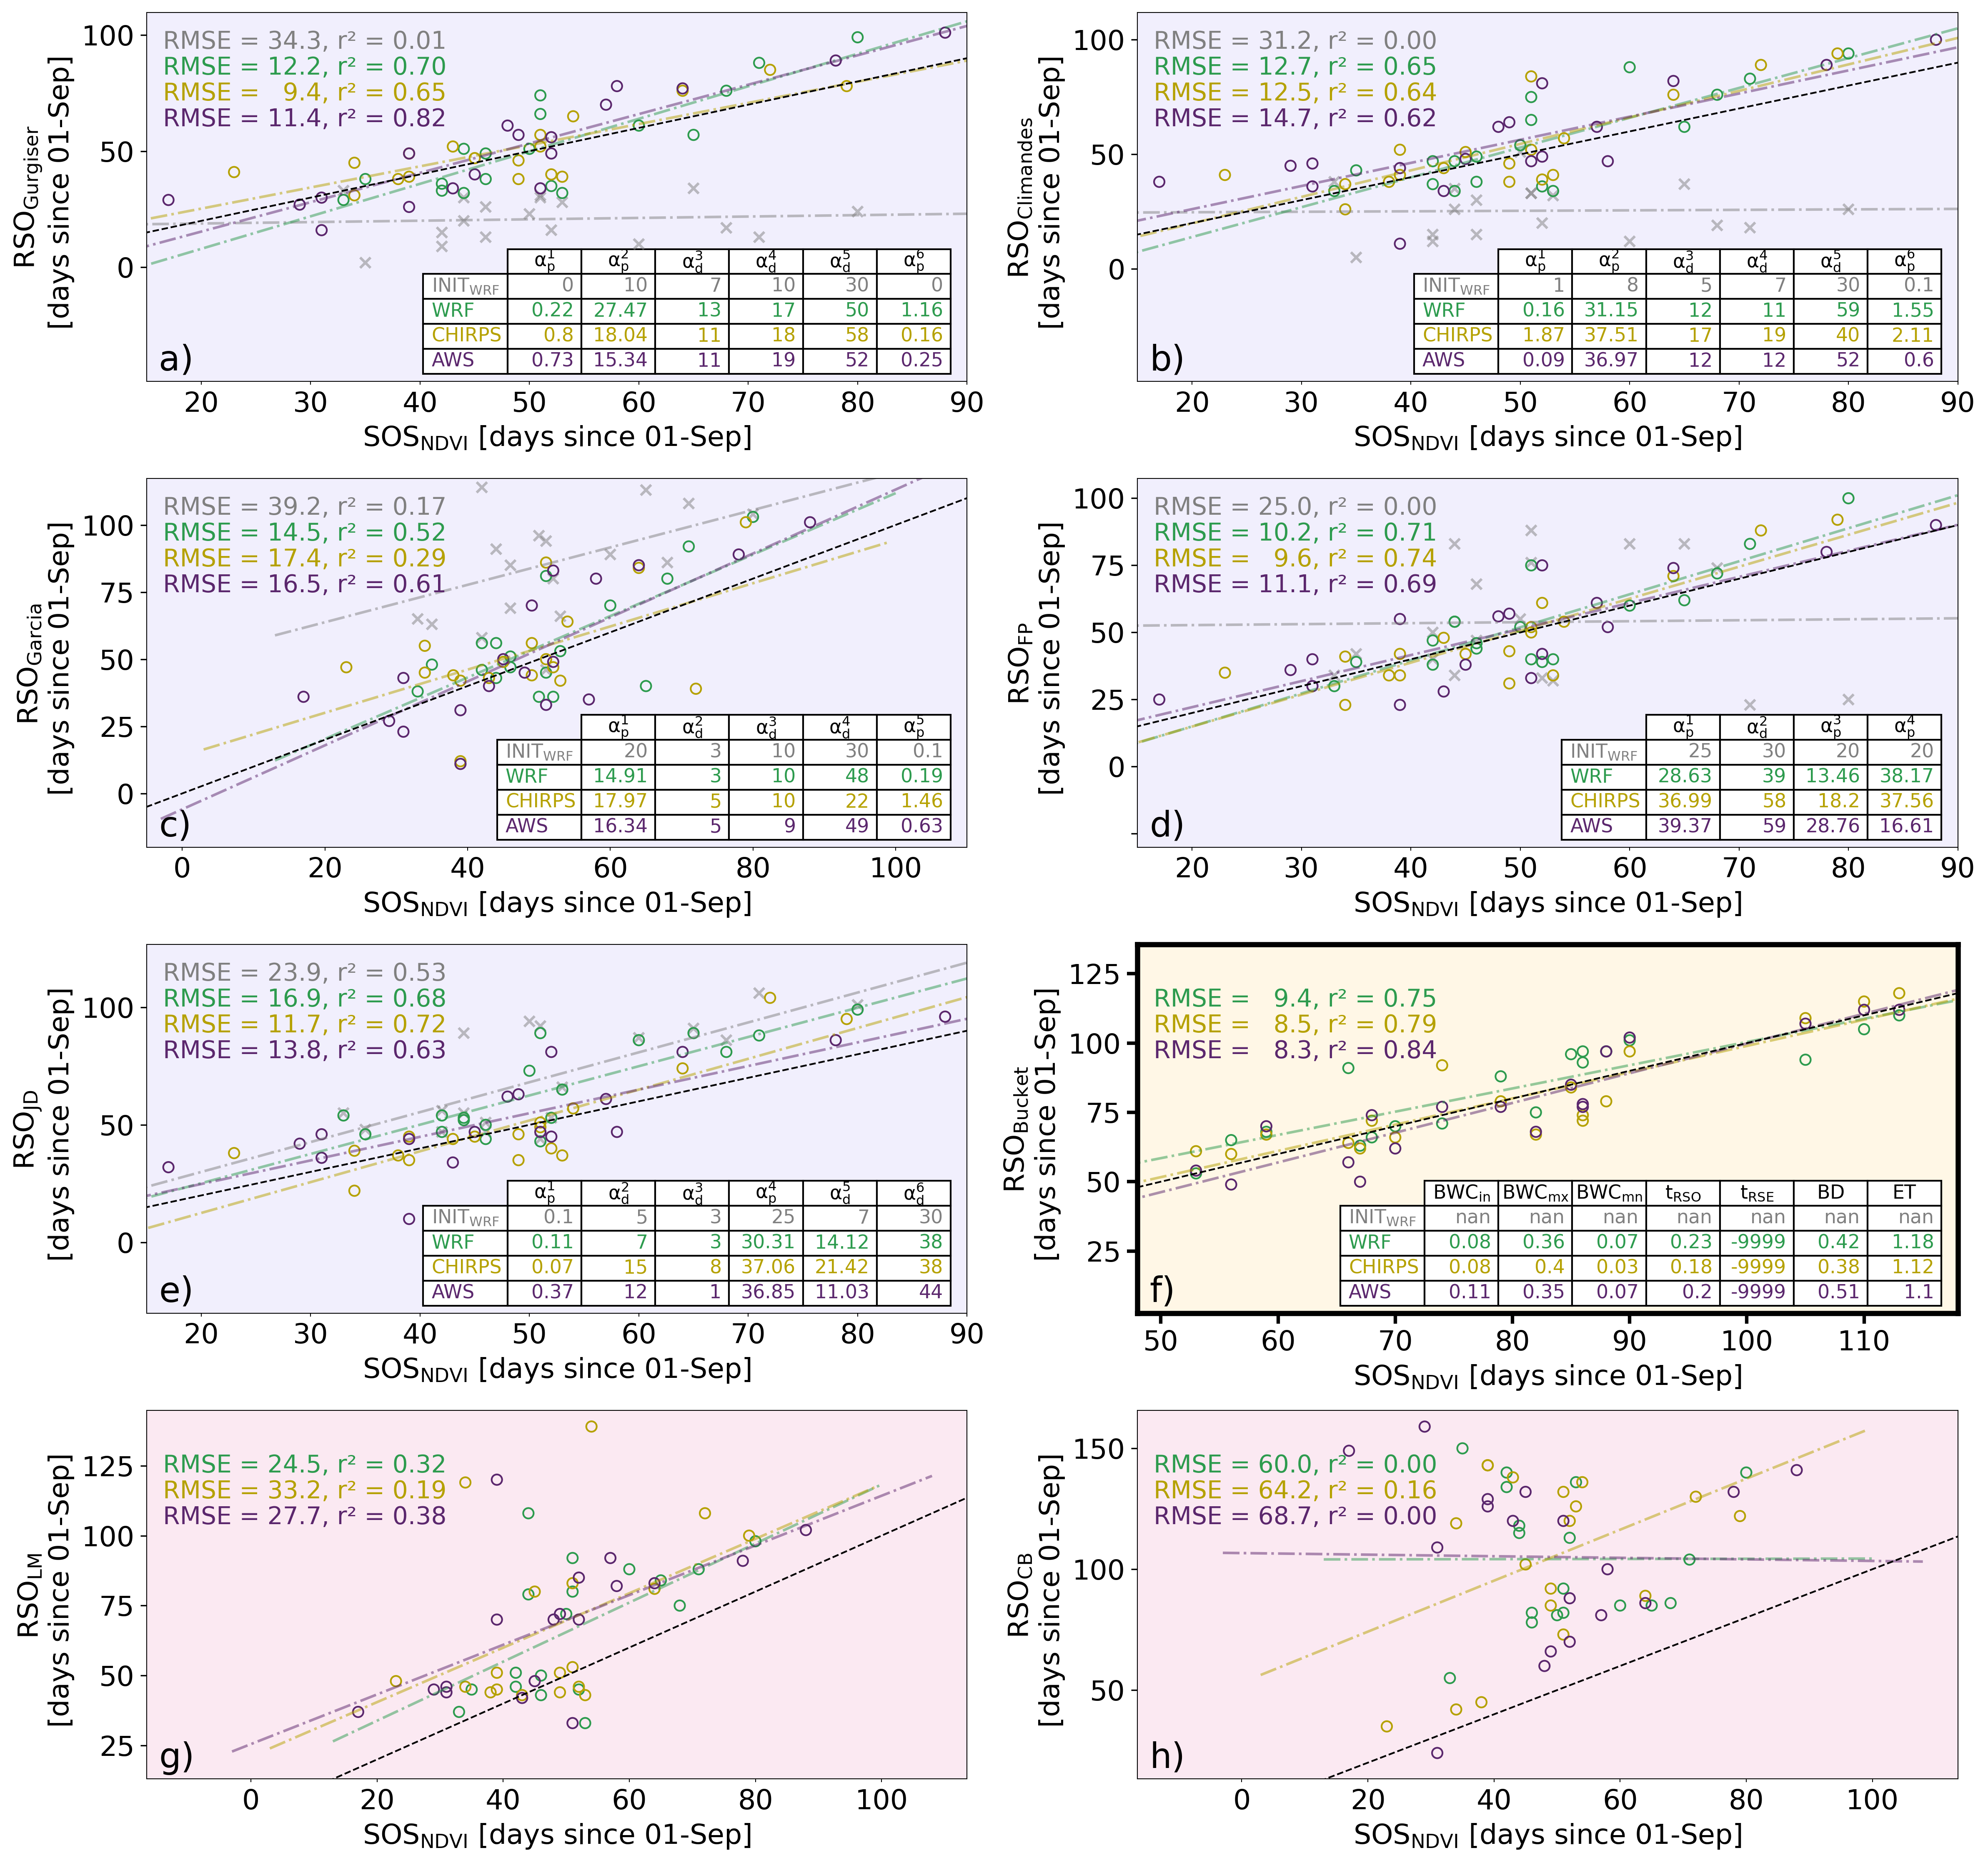

In [4]:
### RSO Scatter plot
fig, axs = plt.subplots(4,2,figsize=(16,15),sharex=False,sharey=False,dpi=300)
axs = axs.ravel()

for i,ax in enumerate(axs[:len(models[:])]): #loop each model
    model = models[i]
    param_list = list()

    ax.set_ylabel('$RSO_{' + names[i] + '}$ \n [days since 01-Sep]')
    for j,(d,v,c) in enumerate(zip(timeseries,validation,colors)): # loop WRF,WRF,CHIRPS,AWS
        try:
            params = list(pS.loc[:, pS.columns.str.startswith(param_idx[i])].dropna(how='all').iloc[:,j])
            if i <= 1: # Gurgiser & Climandes #1 float, #2 float, #3 int, #4 int, #5 int, #6 float
                params[2:5] = [int(p) for p in params[2:5]]
            elif i == 2: # Garcia #1 float #2 int #3 int #4 int #5 float
                params[1:4] = [int(p) for p in params[1:4]]
            elif i == 3: # FP #1 float #2 int #3 float #4 float
                params[1] = int(params[1])
            elif i == 4: # JD #1 float #2 int #3 int #4 float #5 int #6 int
                params[1:3] = [int(p) for p in params[1:3]]
                params[-1] = int(params[-1])
        except:
            params = None
    

        if i < 5: # threshold-based models
            x = model(params=params,ts=d.values,return_onset=True)
            scatter(ax=ax,X=v,Y=x,marker=markers[j],color=c,position=label_pos[j],alpha=alphas[j])
            param_list.append(params)
            ax.set_facecolor(backgrounds[0] + alpha_hex)
        
        elif i == 5: # bucket model
            if j == 0: # dont show init
                param_list.append([np.nan]*7) # just a empty row for init in the bucket model
            else:
                x = model(params=params,ts=d.values)[0]
                v = SOS_b
                scatter(ax=ax,X=v,Y=x,marker=markers[j],color=c,position=label_pos[j])
                param_list.append(params)
                ax.set_facecolor(backgrounds[1] + alpha_hex)
            for spine in ax.spines.values():
                spine.set_linewidth(3) 
            ax.tick_params(axis='both', which='major', length=6, width=2, direction='out')
        else:
            if j == 0: 
                print('')
            else:
                x = model(ts=d.values)[0]
                scatter(ax=ax,X=v,Y=x,marker=markers[j],color=c,position=label_pos[j])
                ax.set_facecolor(backgrounds[2] + alpha_hex)
                

    
    plt.sca(ax)
    xlim,ylim = ax.get_xlim(),ax.get_ylim()    
    if i == 0:
        ax.set_ylim(-49 ,ylim[1]-24)
        ax.set_xlim(15,90)
    elif i == 1:
        ax.set_ylim(-49 ,ylim[1]-12)
        ax.set_xlim(15,90)
    elif i == 2:
        ax.set_ylim(-20 ,ylim[1]-12)
        ax.set_xlim(-5,110)
    elif i == 3:
        ax.set_ylim(-30 ,ylim[1]-12)
        ax.set_xlim(15,90)
        yticklabels = ax.get_yticklabels()
        yticklabels[1].set_visible(False)
    elif i == 4:
        ax.set_ylim(-30 ,ylim[1]-12)
        ax.set_xlim(15,90)
    elif i == 5:
        ax.set_ylim(ylim[0]-20,ylim[1]-5)
        ax.set_xlim(xlim[0]+20,xlim[1]-20)

    else:
        ax.set_ylim(ylim[0]-4,ylim[1])
        ax.set_xlim(xlim[0]-8,xlim[1])

    plot_unity(np.array([-100,200]),np.array([-100,200]),c='k')
    ax.set_xlabel('$SOS_{NDVI}$ [days since 01-Sep]')
    if i < 6: table(ax,param_list,col_labels[i],colors=colors) #get tables where applicable

    set_plot_params(ax=ax,label_size=16, tick_size=16, text_size=14)
    ax.text(0.015,0.03,string.ascii_lowercase[i]+')',fontsize=20,transform = ax.transAxes)
    
fig.tight_layout()
plt.savefig(r'./figures/Fig02.pdf')

# Fig.03: RSE - EOS<sub>NDVI</sub> 

In [5]:
### prepare RSE plot

#creating onsets on the fly
param_idx = ['Gu','Cl','Ga']
timeseries = [ts_w,ts_w,ts_c,ts_a]
models = [gurgiser_RSO,climandes_RSO,garcia_RSO]

intm = []
for i,model in enumerate(models):
    for j,ts in enumerate(timeseries):
        params = list(pS.loc[:, pS.columns.str.startswith(param_idx[i])].dropna(how='all').iloc[:,j])
        intm.append(list(model(params=params,ts=ts,return_onset=True)))

onsets = pd.DataFrame(data=np.array(intm).T,columns = ['Gu_init','Gu_WRF','Gu_CHI','Gu_AWS',
                                                       'Cl_init','Cl_WRF','Cl_CHI','Cl_AWS',
                                                       'Ga_init','Ga_WRF','Ga_CHI','Ga_AWS'])

colors = ['Grey', '#2D9B4E', '#B5A100', '#5B276D']
timeseries = [ts_w,ts_w,ts_c,ts_a]
validation = [EOS_w,EOS_w,EOS_c,EOS_a]
param_idx = ['Gu','Cl','Ga','Bu']
label_pos = ['top','upmid','lowmid','bottom']
models = [gurgiser_RSE,climandes_RSE,garcia_RSE,bucket,Liebmann,CookBuckley_2phase]
names = ['Gurgiser','Climandes','Garcia','Bucket','LM','CB']
markers = ['x','o','o','o']
alphas = [.5,1,1,1]
param_subscripts = [['p','p','d'],
                    ['p','p','d'],
                    ['p','d']]
col_labels = [generate_col_labels(param_subscripts[i]) for i in range(len(param_subscripts))] + [['$BWC_{in}$','$BWC_{mx}$','$BWC_{mn}$','$t_{RSO}$','$t_{RSE}$','$BD$','$ET$']]

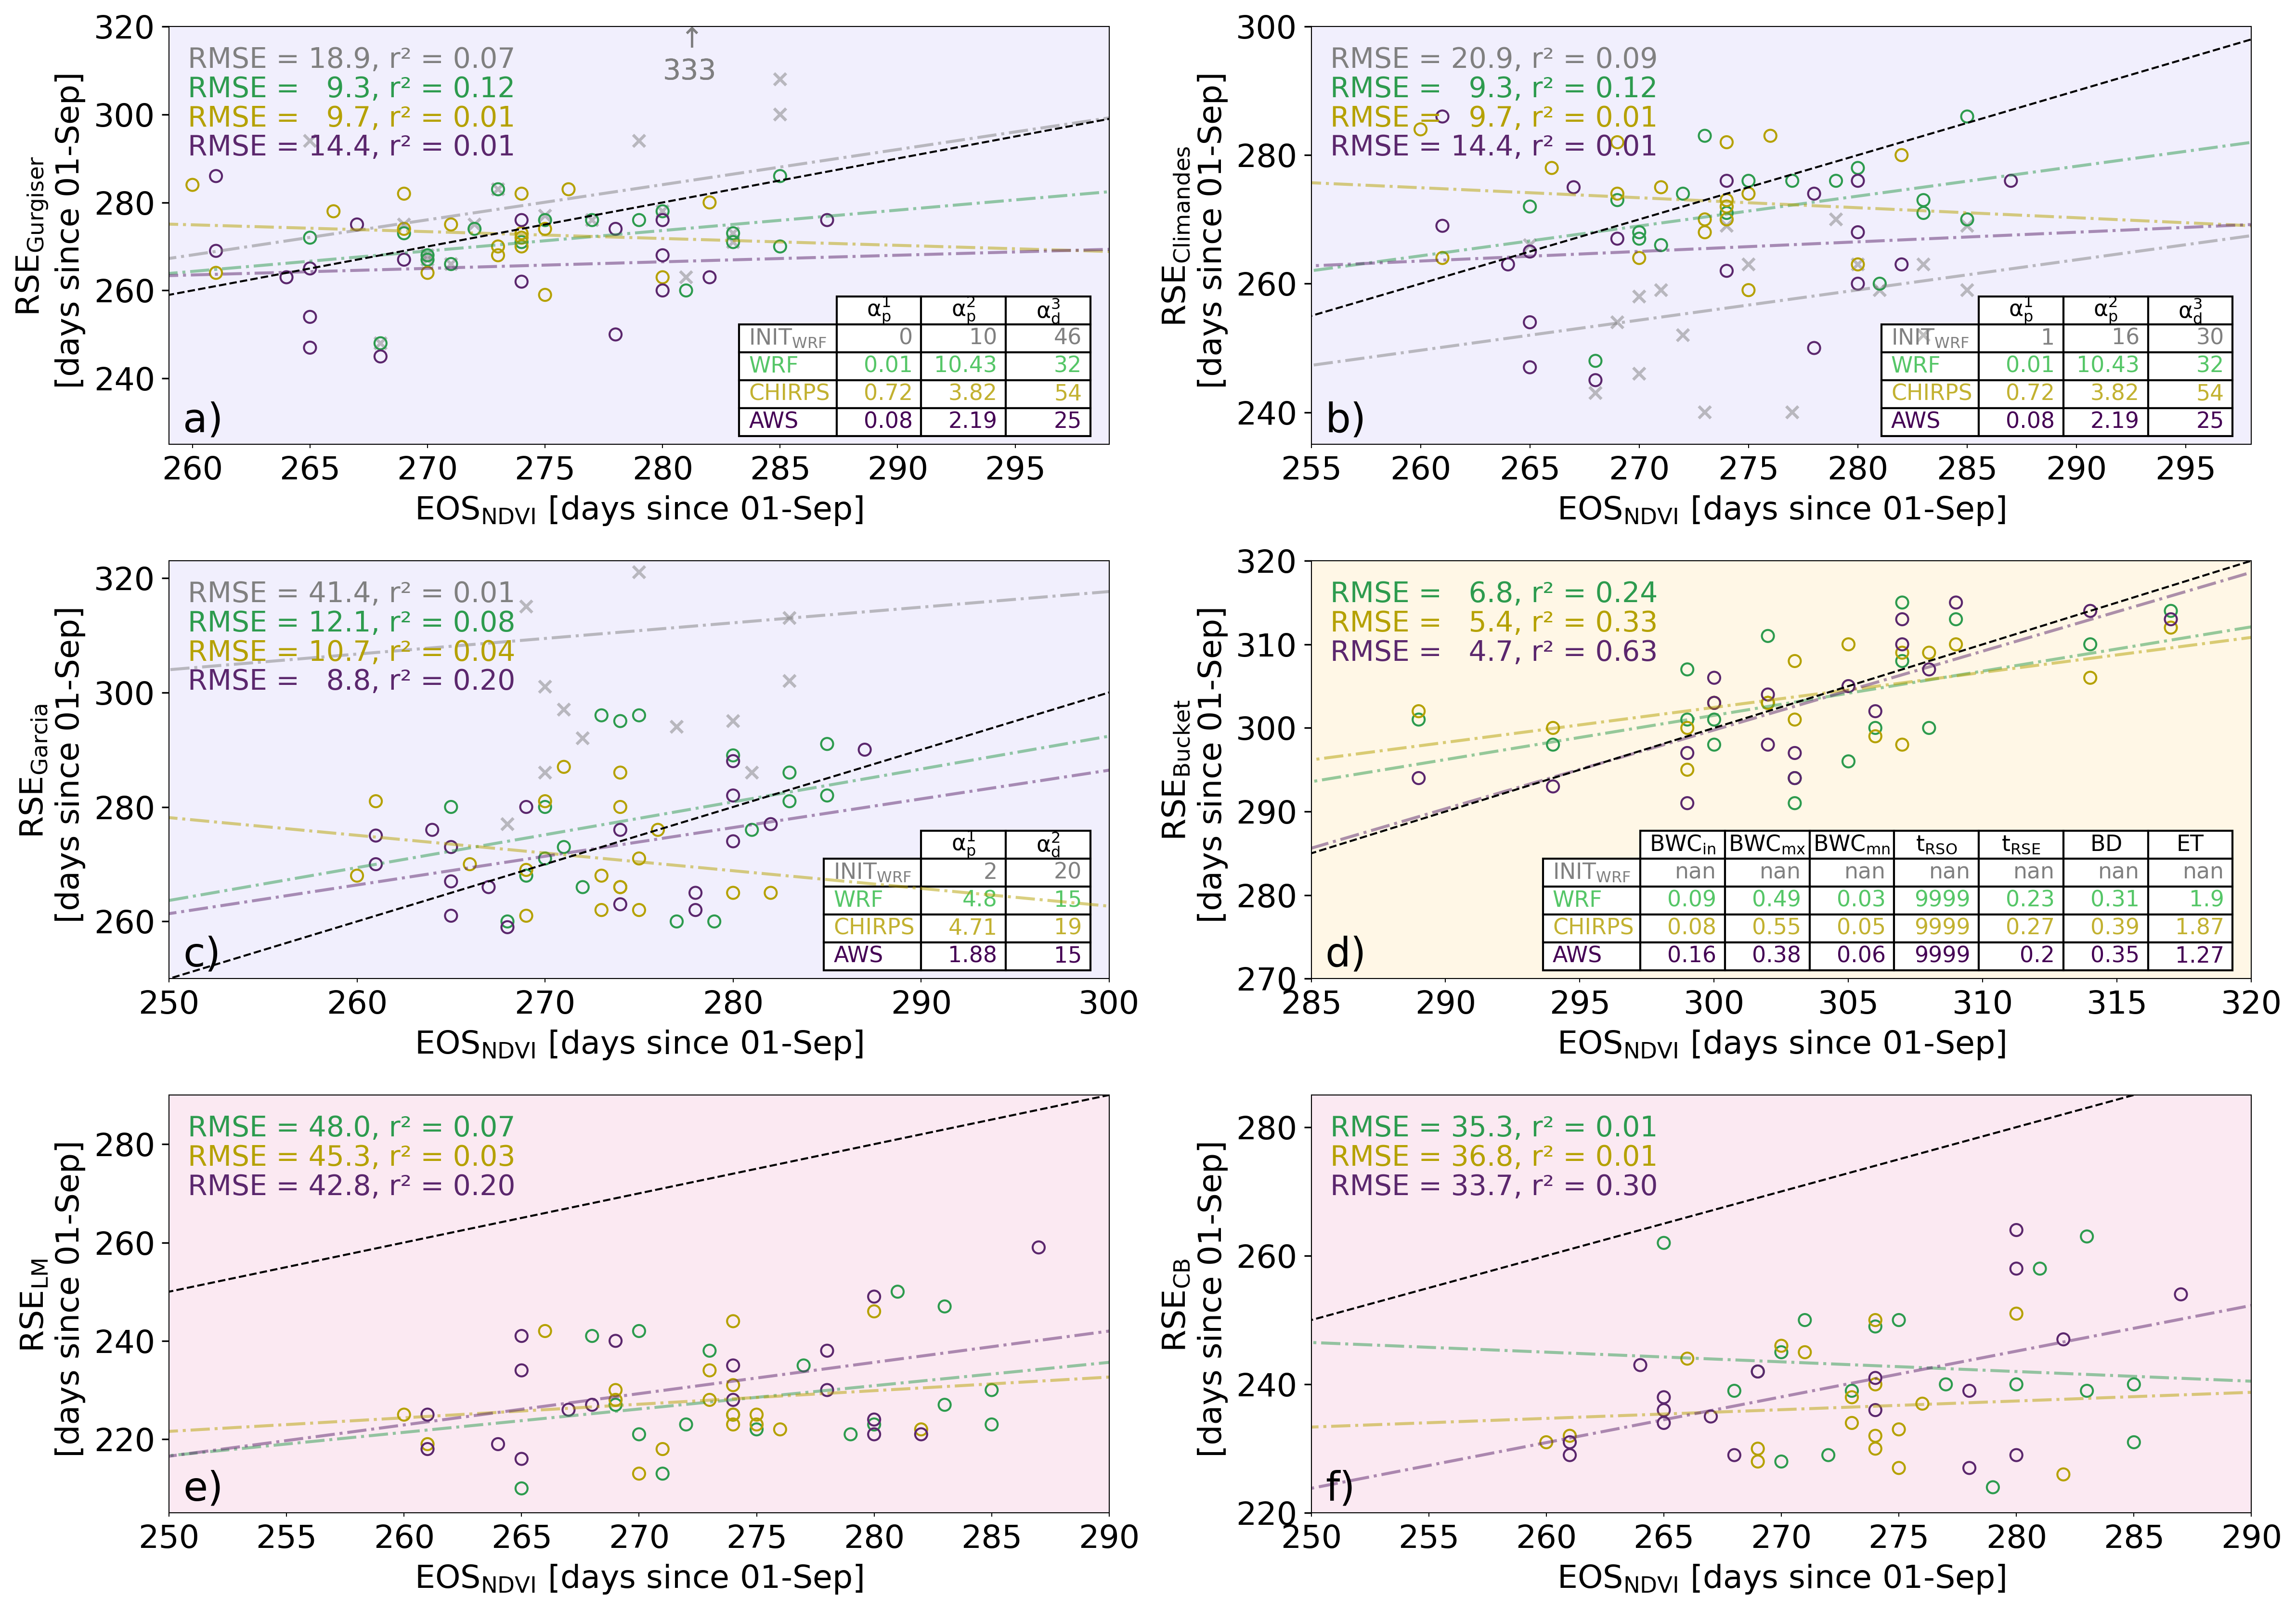

In [6]:
### RSE Scatter plot
fig, axs = plt.subplots(3,2,figsize=(16,11.25),sharex=False,sharey=False,dpi=300)
axs = axs.ravel()

for i,ax in enumerate(axs[:len(models)]): 
    model = models[i]
    param_list = list()
    ax.set_ylabel('$RSE_{' + names[i] + '}$ \n [days since 01-Sep]')

    for j,(d,v,c) in enumerate(zip(timeseries,validation,colors)): # loop WRF,WRF,CHIRPS,AWS
        try:
            params = list(pE.loc[:, pE.columns.str.startswith(param_idx[i])].dropna(how='all').iloc[:,j])
            if i <= 1: 
                params[2] = int(params[2])
            elif i == 2:  
                params[1] = int(params[1])
        except:
            params = None
            
        if i < 3: # threshold-based models
            onset = list(onsets.loc[:,onsets.columns.str.startswith(param_idx[i])].iloc[:,j])
            x = model(params=params,ts=d.values,onsets=onset,return_end=True)
            if i == 0:
                ax.text(280,308,'  ↑\n333',c='Grey',alpha=.75)

                ax.set_ylim(225,320)
                ax.set_xlim(259,299)   
                 
            elif j == 0 and i == 1:
                ax.set_ylim(235,300)
                ax.set_xlim(255,298)

            elif j == 0 and i == 2:
                ax.set_ylim(250,323)
                ax.set_xlim(250,300)
                
            ax.set_facecolor(backgrounds[0] + alpha_hex)                
            scatter(ax=ax,X=v,Y=x,marker=markers[j],color=c,position=label_pos[j],alpha=alphas[j])
            param_list.append(params)

        elif i == 3: # bucket model
            if j == 0: 
                param_list.append([np.nan]*7)
            else:
                x = model(params=params,ts=d.values)[1]
                v = EOS_b
                scatter(ax=ax,X=v,Y=x,marker=markers[j],color=c,position=label_pos[j-1])
                param_list.append(params)
                ax.set_ylim(270,320)
                ax.set_xlim(285,320)
            ax.set_facecolor(backgrounds[1] + alpha_hex)                


        else:
            if j == 0: 
                print('')
            else:
                x = model(ts=d.values)[1]
                scatter(ax=ax,X=v,Y=x,marker=markers[j],color=c,position=label_pos[j-1])
                if i == 4:
                    ax.set_ylim(205,290)
                    ax.set_xlim(250,290)
                elif i == 5:
                    ax.set_ylim(220,285)
                    ax.set_xlim(250,290)     
            ax.set_facecolor(backgrounds[2] + alpha_hex)                
                    
    plt.sca(ax)
    plot_unity(np.array([150,400]),np.array([150,400]),c='k')
    ax.set_xlabel('$EOS_{NDVI}$ [days since 01-Sep]')
    

    
    if i < 4: table(ax,param_list,col_labels[i]) #get tables
    set_plot_params(ax=ax,label_size=16, tick_size=16, text_size=14)
    ax.text(0.015,0.03,string.ascii_lowercase[i]+')',fontsize=20,transform = ax.transAxes)

fig.tight_layout()

plt.savefig(r'./figures/Fig03.pdf')

# Fig. 04: Taylor Diagram

In [7]:
# preparing data RSO
models = [gurgiser_RSO,climandes_RSO,garcia_RSO,FP_RSO,JD_RSO,bucket,Liebmann,CookBuckley_2phase]
param_idx = ['Gu','Cl','Ga','FP','JD','Bu']
timeseries = [ts_w,ts_w,ts_c,ts_a]
validation = [SOS_w,SOS_w,SOS_c,SOS_a]

samples_RSO = [[],[],[],[]]
for i in range(len(models)): #loop each model
    model = models[i]
    param_list = list()
    for j,(d,v) in enumerate(zip(timeseries,validation)): # loop WRF,WRF,CHIRPS,AWS
        try:
            params = list(pS.loc[:, pS.columns.str.startswith(param_idx[i])].dropna(how='all').iloc[:,j])
        except:
            params = None
        if i < 5: # threshold-based models
            ons = model(params=params,ts=d.values,return_onset=True)
        elif i == 5: # bucket
            ons = model(params=params,ts=d.values)[0]
            v = SOS_b
        else: #  Liebmann & CB
            ons = model(ts=d.values)[0]

        ons = np.array(ons)
        samples_RSO[j].append([ons.std(ddof=1)/v.std(), np.corrcoef(ons,v)[0,1]])

#removing Liebmann, CB and Bucket from init
samples_RSO[0].pop(-1);
samples_RSO[0].pop(-2);
samples_RSO[0].pop(-3);

C:\Users\Biomet\miniconda3\envs\lorenz_main\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Biomet\miniconda3\envs\lorenz_main\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [8]:
### preparing data RSE
models = [gurgiser_RSE,climandes_RSE,garcia_RSE,bucket,Liebmann,CookBuckley_2phase]
param_idx = ['Gu','Cl','Ga','Bu']
timeseries = [ts_w,ts_w,ts_c,ts_a]
validation = [EOS_w,EOS_w,EOS_c,EOS_a]

samples_RSE = [[],[],[],[]]
for i in range(len(models)): #loop each model
    model = models[i]
    param_list = list()
    for j,(d,v) in enumerate(zip(timeseries,validation)): # loop WRF,WRF,CHIRPS,AWS
        try:
            params = list(pE.loc[:, pE.columns.str.startswith(param_idx[i])].dropna(how='all').iloc[:,j])
        except:
            params = None

        if i < 3: # threshold-based models
            onset = list(onsets.loc[:,onsets.columns.str.startswith(param_idx[i])].iloc[:,j])
            ret = model(params=params,ts=d.values,onsets=onset,return_end=True)
        elif i == 3: #bucket
            ret = model(params=params,ts=d.values)[1]
            v = EOS_b  
        else: # Liebmann & CB
            ret = model(ts=d.values)[1]

        samples_RSE[j].append([ret.std(ddof=1)/v.std(), np.corrcoef(ret,v)[0,1]])

#removing Liebmann, CB and Bucket from init
samples_RSE[0].pop(-1);
samples_RSE[0].pop(-2);
samples_RSE[0].pop(-3);

In [9]:
### preparing Taylor diagram
colors = ['Grey', '#2D9B4E', '#B5A100', '#5B276D']
markers = dict(RSO=["o","s","^","P","v",'*','d',"h"],RSE=["o","s","^",'*','d',"h"])
labels = dict(RSO=['Gurgiser','Climandes','Garcia','FP','JD','Bucket','LM','CB'],
              RSE=['Gurgiser','Climandes','Garcia','Bucket','LM','CB'])

print('double check the outliers:')
print(samples_RSE[0][0],samples_RSE[0][1])

samples_RSE[0][0] = [2.75, samples_RSE[0][0][1]] # 3.1
samples_RSE[0][1] = [2.75, samples_RSE[0][1][1]] # 3.4
print('now:')
print(samples_RSE[0][0],samples_RSE[0][1])

rects = dict(RSO=221,RSE=222)
sini = dict(RSO=samples_RSO[0],RSE=samples_RSE[0])
swrf = dict(RSO=samples_RSO[1],RSE=samples_RSE[1])
schi = dict(RSO=samples_RSO[2],RSE=samples_RSE[2])
saws = dict(RSO=samples_RSO[3],RSE=samples_RSE[3])

double check the outliers:
[3.0992154334914326, 0.2577651337877774] [3.4475674626574695, 0.07921673938208398]
now:
[2.75, 0.2577651337877774] [2.75, 0.07921673938208398]


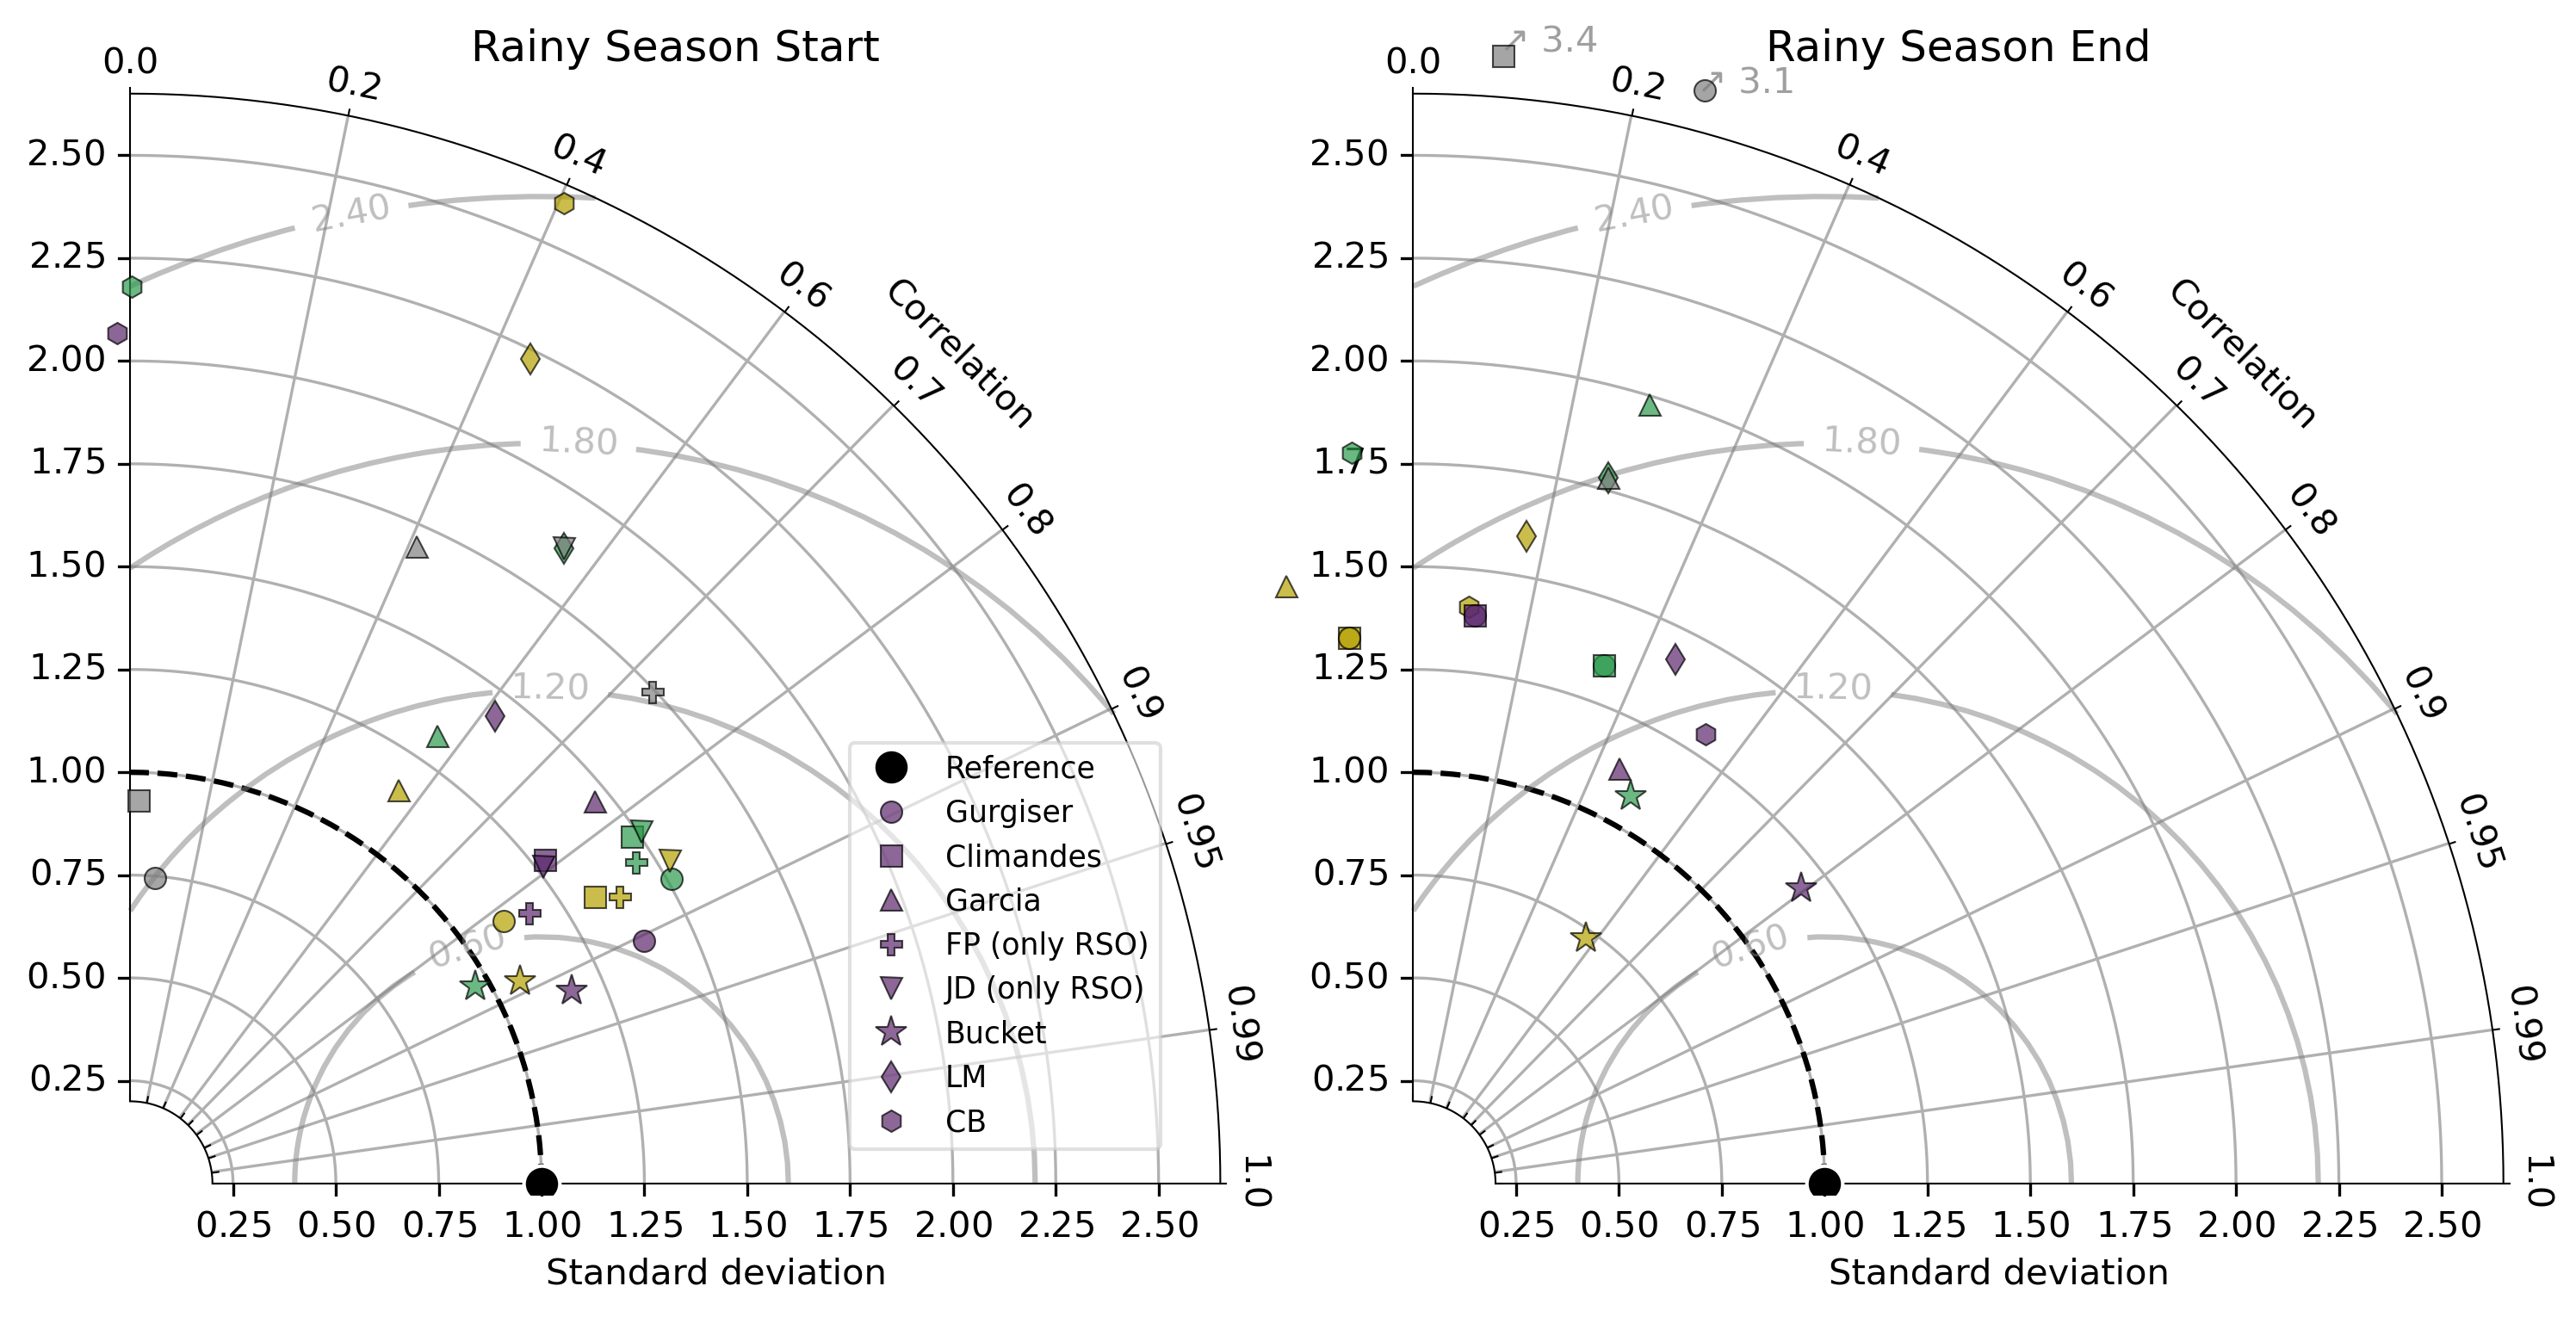

In [10]:
# plot it
fig = plt.figure(figsize=(10,10),dpi=300)

for param in ['RSO','RSE']:
    dia = TaylorDiagram(1, fig=fig, label='Reference',rect=rects[param],srange=(0.2,2.65), extend=False)
    add_contours(dia,param=param)
    nice_reference_point(dia) # plot a fancy reference point
    
    # Add  models to Taylor diagram
    for i,res in enumerate([sini,swrf,schi,saws]):

        for j, (stddev, corrcoef) in enumerate(res[param]):
            ms = 6
            if j == len(res[param])-3 and i != 0:
                ms = 9
            dia.add_sample(stddev, corrcoef,
                           marker=markers[param][j], ms=ms,clip_on=False,
                           mfc=colors[i], mec='k',mew=.5,zorder=11,alpha=.7,
                           linestyle = 'None',label=labels[param][j])

    set_plot_params(ax=dia._ax,label_size=16, tick_size=16, text_size=14)

    if param == 'RSO':
        leglabs = [dia.samplePoints[0].get_label()] + [p.get_label() for p in dia.samplePoints][-8:]  # just get the iteration
        leglabs[4] = 'FP (only RSO)'
        leglabs[5] = 'JD (only RSO)'
        leg = dia._ax.legend([dia.samplePoints[0]] + dia.samplePoints[-8:],leglabs,
                   numpoints=1, prop=dict(size='small'),bbox_to_anchor=(.95,.42),#(.34,.973),
                      frameon=True,framealpha=.6,fancybox=True)
        dia._ax.set_title('Rainy Season Start')
             
    else:
        dia._ax.text(0.69,2.65,'↗ 3.1',c='Grey',alpha=.75)
        dia._ax.text(0.21,2.75,'↗ 3.4',c='Grey',alpha=.75)
        dia._ax.set_title('Rainy Season End')


fig.tight_layout()
plt.savefig(r'./figures/Fig04.pdf',bbox_inches='tight')